In [1]:
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
from torchvision import transforms
import torch.nn.functional as F
from datetime import datetime
import random
import math

In [21]:
yolo = YOLO("/kaggle/input/deeplearningproject/best.pt", verbose = False)

In [18]:
# define paths to image folders
folder_paths = {
    'New York': '/kaggle/input/deeplearningproject/data_analysis/data_analysis/New_York',
    'New Orleans': '/kaggle/input/deeplearningproject/data_analysis/data_analysis/New_Orleans',
    'London': '/kaggle/input/deeplearningproject/data_analysis/data_analysis/London'
}

In [25]:
def count_people_from_yolo(image_path, model):
    # Perform inference
    results = model(image_path, verbose = False)
    
    # Access the first result in the list of results
    detections = results[0]
    
    # Extract bounding boxes and class IDs
    class_ids = detections.boxes.cls.cpu().numpy()  # Class IDs
    
    # Count the number of people detected
    person_count = sum(class_id == 0 for class_id in class_ids)  # Class ID 0 for 'person'
    
    return person_count

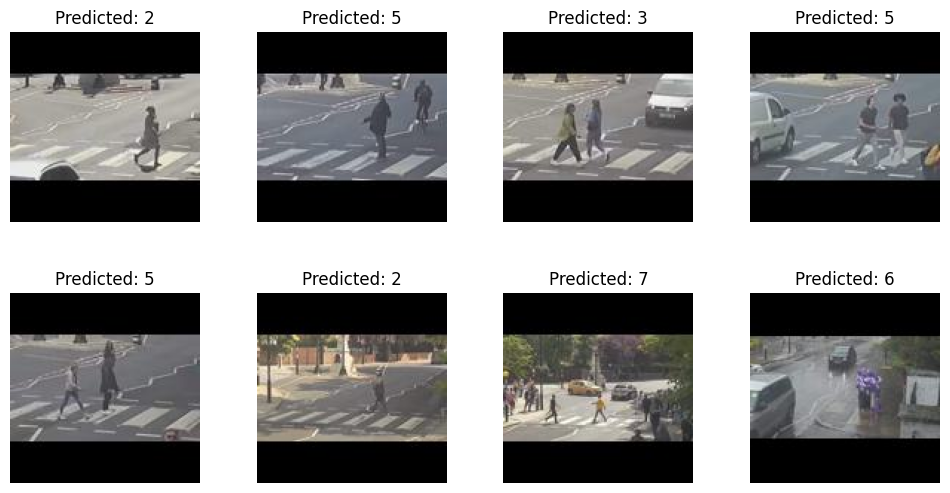

In [26]:
# visualize how model works on the images

def visualize_prediction(model, city, year, number_of_images):
    image_dir = folder_paths[city]
    image_files = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg"):
            parts = filename.split('_')
            city_name = parts[0]
            date = parts[1]
            file_year = date.split('-')[-1]
            if file_year == year:
                image_files.append(filename)
    
    # Randomly select indices
    random_indices = random.sample(range(len(image_files)), number_of_images)
    
    rows = math.ceil(number_of_images / 4)
    cols = min(4, number_of_images)

    fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, idx in enumerate(random_indices):
        filename = image_files[idx]
        image_path = os.path.join(image_dir, filename)
        predicted_count = count_people_from_yolo(image_path, model)
        image = Image.open(image_path).convert('RGB')

        if rows == 1 and cols == 1:
            ax = axes
        elif rows == 1 or cols == 1:
            ax = axes[i]
        else:
            ax = axes[i // cols, i % cols]

        ax.imshow(image)
        ax.set_title(f"Predicted: {int(predicted_count)}")
        ax.axis('off')

    plt.show()

# Visualize the prediction for the first image in the validation set
visualize_prediction(yolo, "London", "2022", number_of_images=8)

In [27]:
results = {
    "London": {
        "2019": {"05-08-2019": [], "05-09-2019": [], "05-10-2019": [], "05-11-2019": [],
                 "05-12-2019": [], "05-13-2019": [], "05-14-2019": []},
        "2020": {"05-08-2020": [], "05-09-2020": [], "05-10-2020": [], "05-11-2020": [],
                 "05-12-2020": [], "05-13-2020": [], "05-14-2020": []},
        "2022": {"05-08-2022": [], "05-09-2022": [], "05-10-2022": [], "05-11-2022": [],
                 "05-12-2022": [], "05-13-2022": [], "05-14-2022": []}
    },
    "New York": {
        "2019": {"06-24-2019": [], "06-25-2019": [], "06-26-2019": [],
                 "06-27-2019": [], "06-28-2019": [], "06-29-2019": [], "06-30-2019": []},
        "2020": {"06-24-2020": [], "06-25-2020": [], "06-26-2020": [],
                 "06-27-2020": [], "06-28-2020": [], "06-29-2020": [], "06-30-2020": []},
        "2022": {"06-24-2022": [], "06-25-2022": [], "06-26-2022": [],
                 "06-27-2022": [], "06-28-2022": [], "06-29-2022": [], "06-30-2022": []}
    },
    "New Orleans": {
        "2019": {"05-21-2019": [], "05-22-2019": [], "05-23-2019": [],
                 "05-24-2019": [], "05-25-2019": [], "05-26-2019": [], "05-27-2019": []},
        "2020": {"05-21-2020": [], "05-22-2020": [], "05-23-2020": [],
                 "05-24-2020": [], "05-25-2020": [], "05-26-2020": [], "05-27-2020": []},
        "2022": {"05-21-2022": [], "05-22-2022": [], "05-23-2022": [],
                 "05-24-2022": [], "05-25-2022": [], "05-26-2022": [], "05-27-2022": []}
    }
}

for city, path in folder_paths.items():
    
    for filename in os.listdir(path):
        if filename.endswith(".jpg"):
            parts = filename.split('_')
            city_name = parts[0]
            date = parts[1]
            year = date.split('-')[-1]
            
            image_path = os.path.join(path, filename)
            image = Image.open(image_path).convert('RGB')
            count = count_people_from_yolo(image_path, yolo)
            
            if year in results[city]:
                results[city][year][date].append(count)

In [28]:
averages = {}

for city, years in results.items():
    averages[city] = {}
    for year, days in years.items():
        averages[city][year] = {}
        for day, counts in days.items():
            avg_count = sum(counts) / len(counts)
            averages[city][year][day] = avg_count

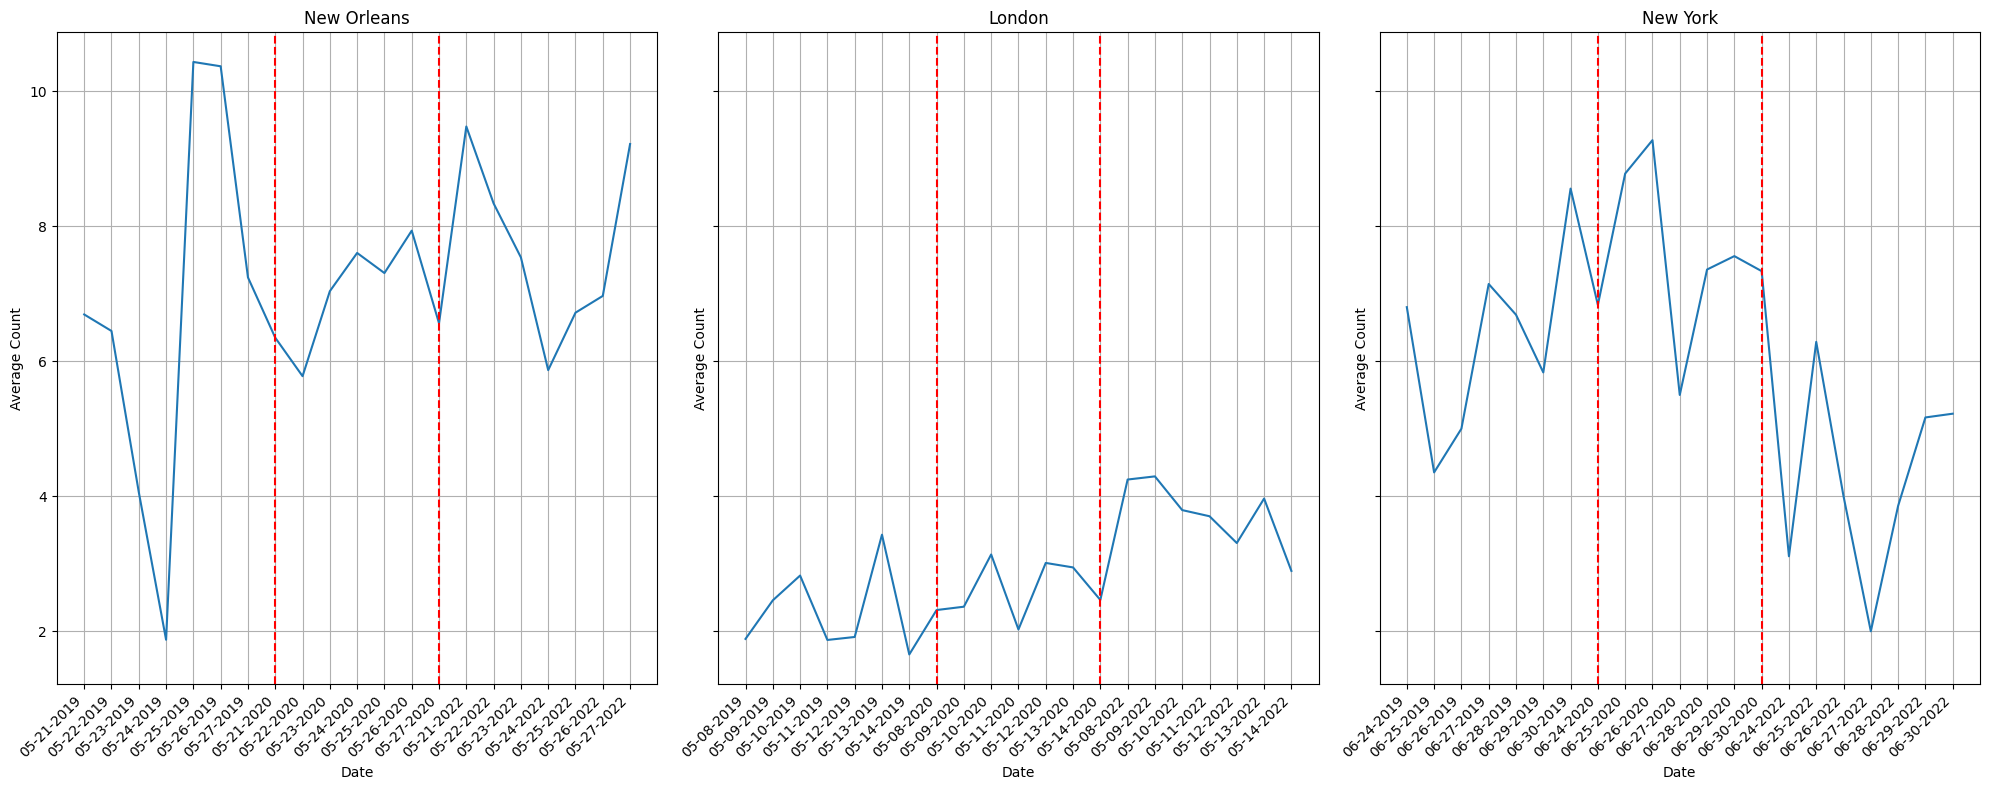

In [29]:
def flatten_averages(averages):
    flattened = []
    for city, years in averages.items():
        for year, date in years.items():
            for date, avg_count in date.items():
                flattened.append((city, date, avg_count))
    return flattened

data = flatten_averages(averages)

fig, axs = plt.subplots(1, 3, figsize=(20, 8), sharex=False, sharey=True)

cities = list(set(item[0] for item in data))
first_dates_2020 = {"London": "05-08-2020",
                    "New York": "06-24-2020",
                    "New Orleans": "05-21-2020"}
last_dates_2020 = {"London": "05-14-2020",
                   "New York": "06-30-2020",
                   "New Orleans": "05-27-2020"}

for i, city in enumerate(cities):
    city_data = [(date, avg_count) for c, date, avg_count in data if c == city]
    
    if city_data:
        dates, counts = zip(*city_data)
        axs[i].plot(dates, counts, label=city)
        axs[i].set_title(f'{city}')
        axs[i].set_xlabel('Date')
        axs[i].set_ylabel('Average Count')
        axs[i].grid(True)
        plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=45, ha='right')
        axs[i].axvline(x=first_dates_2020[city], color="red", linestyle ="--")
        axs[i].axvline(x=last_dates_2020[city], color="red", linestyle ="--")

plt.tight_layout()
plt.show()